# **1.** **Frame the Problem and Look at the Big Picture**

**Project Goal:**
* Model’s output (a prediction of a district’s `median housing price`) will determine whether it is worth investing in a given area. Getting this right is critical, as it directly affects revenue.

**Designing the System:**
* `Supervised Learning` because model can be trained with labeled examples
* Typical `Regression` task since the model will be asked to predicted a value
  * More specifically, this is a `multiple regression` problem, since the system will use multiple features to make prediction and 
  * It is also `Univariate regression` problem, since we are only trying to predict a single value for each district.
* There is no continuous flow of data coming into the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory, so plain ***batch learning*** should do just fine.

**Select a Performance Measure:**
* RMSE (Root Mean Square Error)
* MAE (Mean Absolute Error)<br>
  We will use both<br><br>
**NOTES:**
* The RMSE is more sensitive to outliers than the MAE.
* If Outliers are rare RMSE performs very well


**Libraries to Use In Project:**

In [248]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# My Scripts
from data_visualization_utils import save_fig

# **2.** **Get the Data**

## **2.1.** **Download and Load the Dataset**

In [249]:
# Load the Dataset
df = pd.read_csv('../data/housing.csv')

## **2.2.** **Take a Quick Look at the Data Structure**

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [251]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


**Quick Observations:**
* We have 20640 entries and 10 features
* we can quickly identify columns with missing data: Only `total_bedrooms` have null values.
* All attributes are numerical, except for `ocean_proximity`

**Feature Summary:**

*Features:*

1. `longitude`: A measure of how far west a house is; a higher value is farther west
2. `latitude`: A measure of how far north a house is; a higher value is farther north
3. `housing_median_age`: Median age of a house within a block; a lower number is a newer building
4. `total_rooms`: Total number of rooms within a block
5. `total_bedrooms`: Total number of bedrooms within a block
6. `population`: Total number of people residing within a block
7. `households`: Total number of households, a group of people residing within a home unit, for a block
8. `median_income`: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9.  `ocean_proximity`: Location of the house w.r.t ocean/sea
    
*Target Variable:*

1. `median_house_value`: Median house value for households within a block (measured in US Dollars)

When we look at the top five rows, noticed that `ocean_proximity` repetitive, which means that it is probably categorical attribute.<br>
Let's look at what categories exist and how many districts belong to each category:

In [252]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Let's look at the other fields; summary of the numerical attributes

In [253]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


**We can find possible skewness from statistics:**
* `total_rooms`: mean 2635.76, median 1447.75 --- *right (positive) skewness.*
* `total_bedrooms`: mean 537.87, median 435 --- *right (positive) skewness.*
* `population`: mean 1425.47, median 1166 --- *right (positive) skewness.*
* `households`: mean 499.53, median 409 --- *right (positive) skewness.*
* `median_income`: mean 3.87, median 3.53 --- *right (positive) skewness.*

Let's look at the histogram for each numerical attribute for understanding data we're dealing with

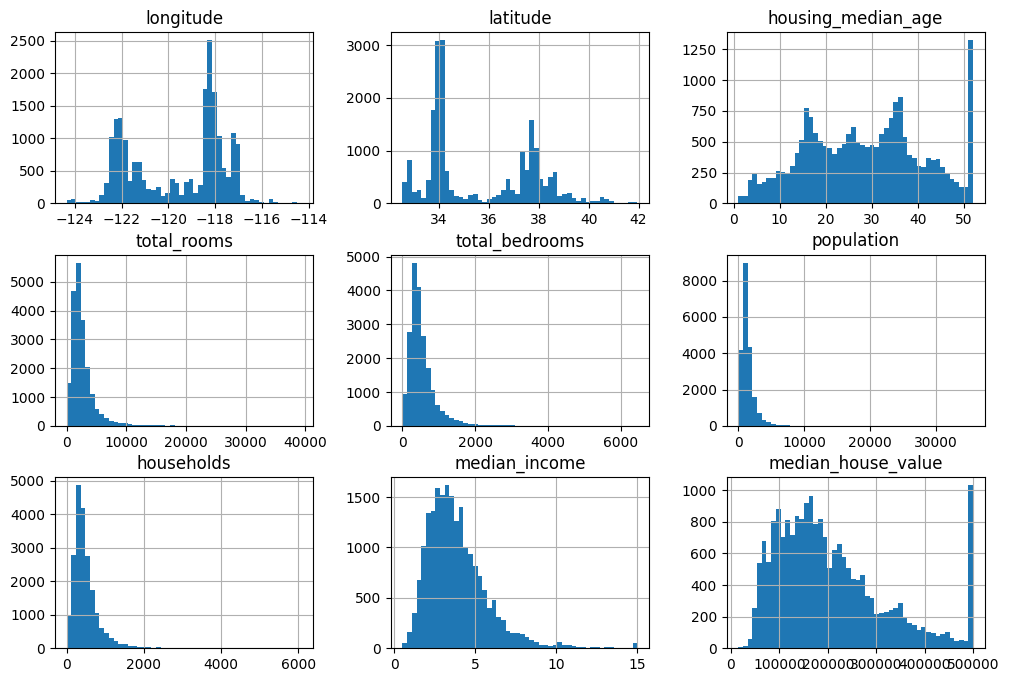

In [254]:
df.hist(bins=50, figsize=(12, 8))
plt.show()

**Observation from Histograms:**

1. `median income` attribute:
   * Has been scaled and capped at ***15 (15.0001)*** for higher incomes, and at ***0.5 (0.4999)*** for lower median incomes
   * The numbers represent roughly tens of thousands of dollars *(eg. 3 is $30,000)*
2. `housing median age` attribute:
   * capped at 52.0 for higher house ages
3. `median house value` attribute *(Target Variable)*:  
   * Capped at 500001.00 for higher, this maybe a problem because model may learn that prices never go beyond that limit, If we want to predict house prises beyond, we have to options:
     1. Collect proper labels
     2. Remove those districts from the training and test set
4. Attributes have very different scales. We need to correct this.
5. Many histograms are **skewed right**, this may make it harder some ML algorithms to detect patterns. We need try transform these attributes to have more symmetrical and bell-shaped distributions.

## **2.3.** **Create Test Set:**

*1. Automatic Partition with Scikit-learn Library:*

In [255]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

*2. Stratified Sampling:*

* Find more imported feature for predicting `median_house_value`

In [256]:
df.select_dtypes(include=['number']).corr()['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

Most imported attribute is `median_income` with 0.688075. We want to ensure that the test set representative of various categories of income.

Since the median income is a continuous numerical attribute, first we need to create an income category attribute. Let's look at the histogram of `median_income`

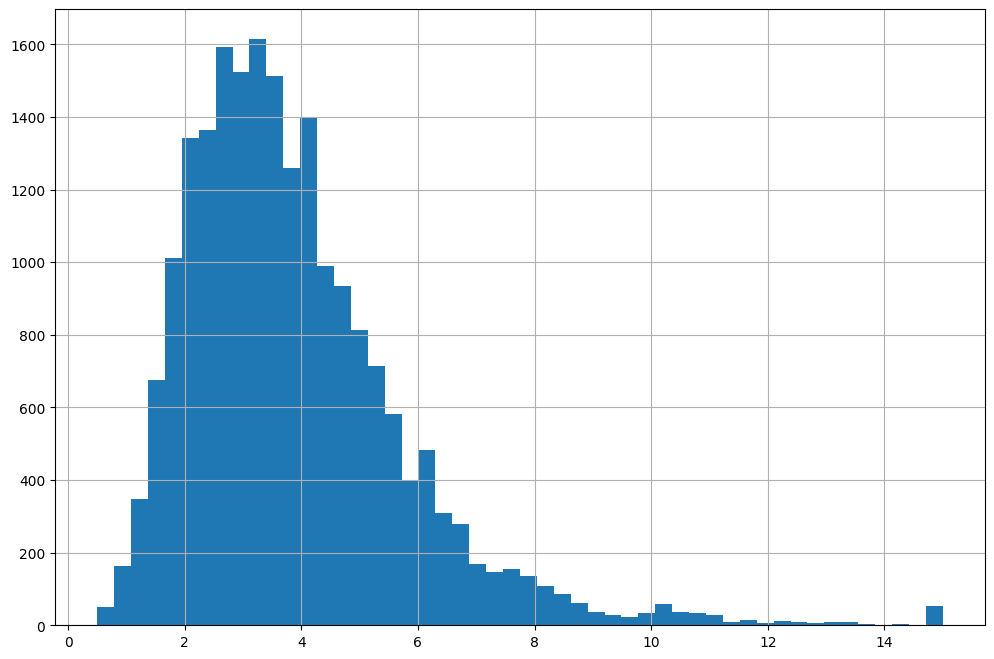

In [257]:
df['median_income'].hist(bins=50, figsize=(12, 8))
plt.show()

Most median income values clustered around 1.5 to 6, but some median incomes go far beyond 6. To avoid sampling bias we need to have sufficient number of instances of a stratum in dataset for each stratum.<br>
**NOTE:** We should not have too many strata, and each stratum should be large enough.

<Axes: xlabel='income_cat'>

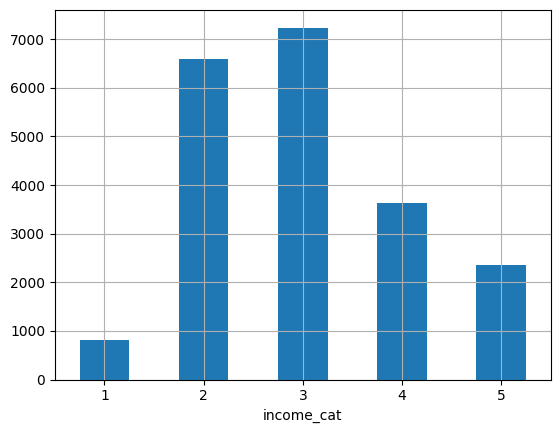

In [258]:
df['income_cat'] = pd.cut(df['median_income'],
                          bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                          labels=[1, 2, 3, 4, 5])

df['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)

In [259]:
strat_train_set, strat_test_set = train_test_split(
    df, test_size=0.2, stratify=df['income_cat'],random_state=42)

Let's compare proportion of random split and stratified split

In [260]:
def income_cat_proportions(data):
    return data['income_cat'].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(df),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),    
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.02,0.36,0.97
2,31.88,31.88,32.44,-0.02,1.73
3,35.06,35.05,35.85,-0.01,2.27
4,17.63,17.64,16.74,0.03,-5.06
5,11.44,11.43,10.95,-0.08,-4.32


The test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is skewed. 

We don't need to use the income_cat column again; we might drop it, and revert the data back to its original state:

In [261]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

# **3.** **Explore the Data**

In [262]:
# Copy the training Set
housing = strat_train_set.copy()

## **3.1.** **Visualizing Geographical Data**

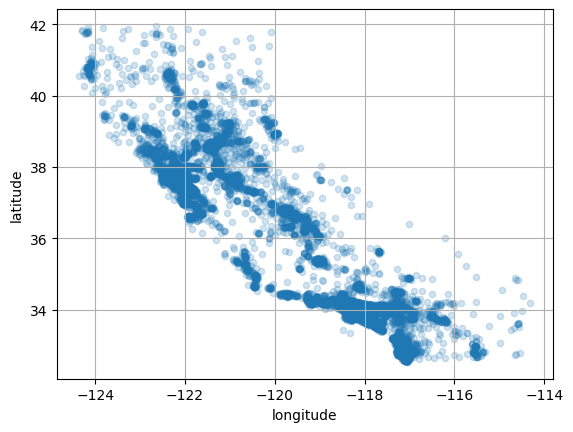

In [263]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, 
             alpha=0.2)
plt.show()

We can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high-density areas in the Central Valley (in particular, around Sacramento and Fresno).

Let's look at te housing prices:
* `s`: The radius of each circle represents the district's **population**
* `c`: The color represents the **price**

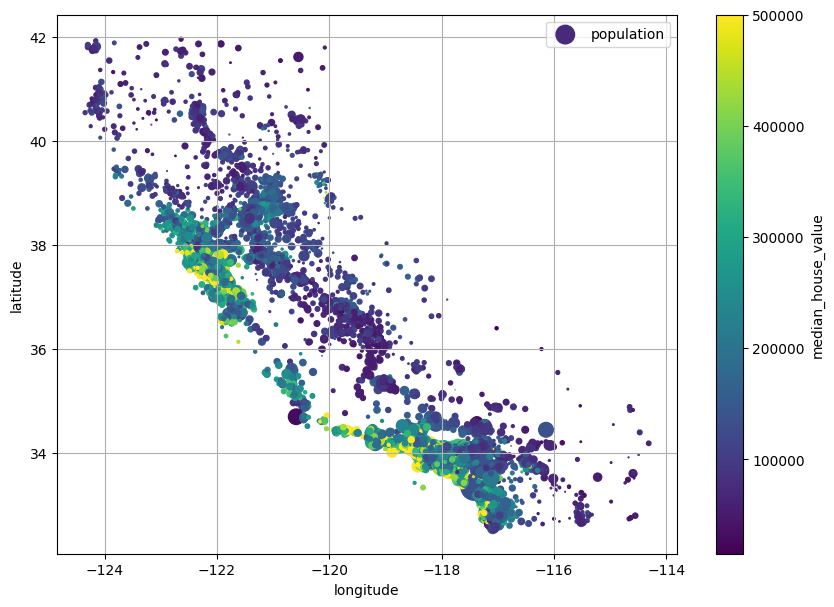

In [264]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing['population'] / 100, label="population",
             c="median_house_value", cmap="viridis", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

This image tells us that the housing prices are very much related to the location *(eg. close to the ocean)*

Let's see with california image

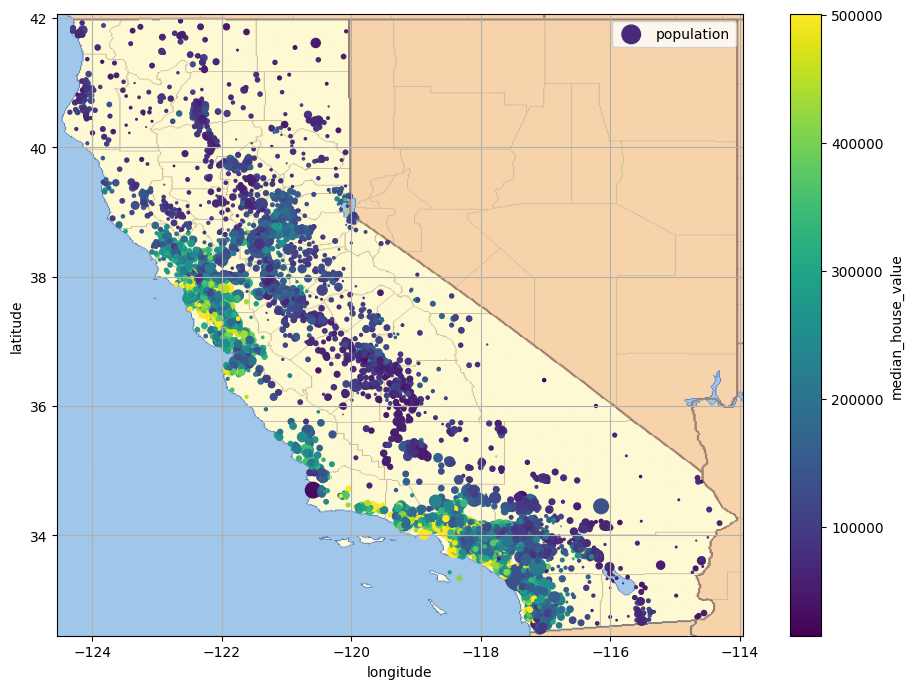

In [265]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing['population'] / 100, label="population",
             c="median_house_value", cmap="viridis", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread('../images/california.png')
axis = -124.55, -113.95, 32.45, 42.05
plt.imshow(california_img, extent=axis)

save_fig('california_housing_prices_plot')
plt.show()

## **3.2.** **Look for Correlations**

In [266]:
corr_matrix = housing.select_dtypes(include=[np.number]).corr()

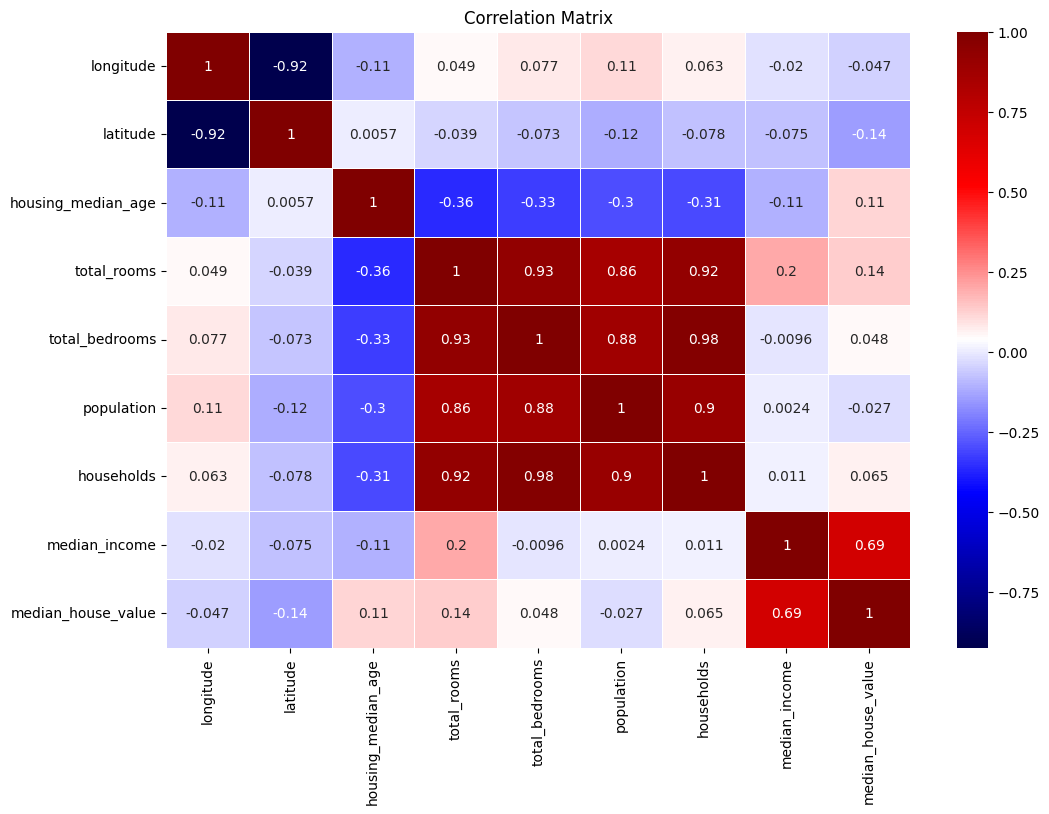

In [267]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='seismic', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [268]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

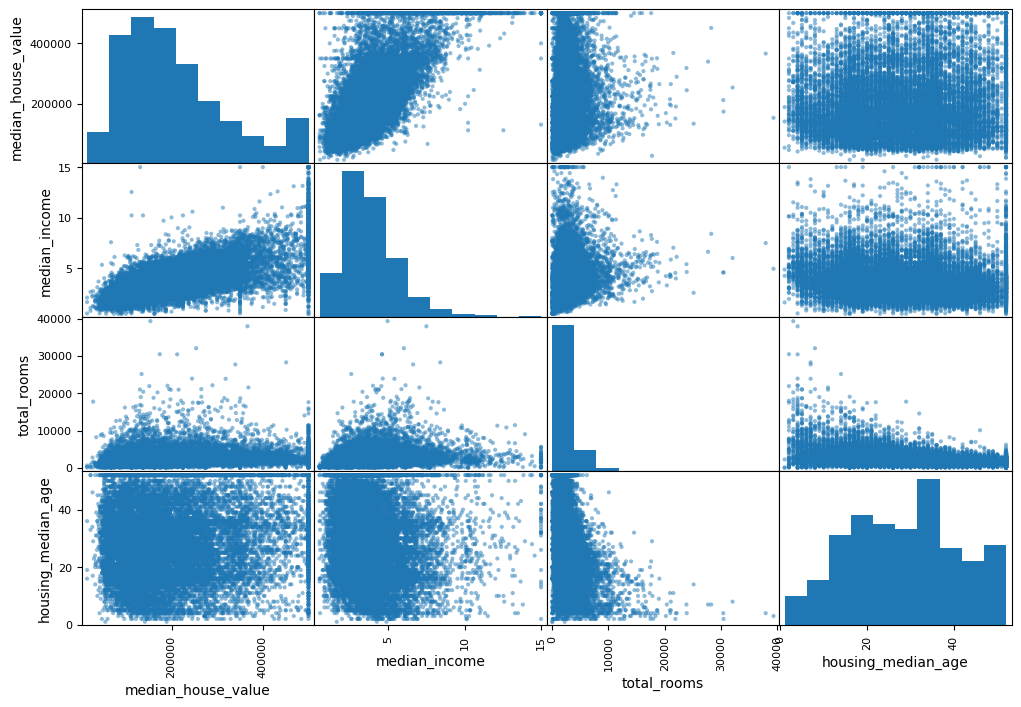

In [269]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value",
              "median_income",
              "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

We saw correlation matrix, now let's produce useful features

## **3.3.** **Feature Extraction**

In [270]:
housing["room_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [271]:
corr_matrix = housing.select_dtypes(include=[np.number]).corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
room_per_house        0.146255
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
people_per_house     -0.021991
population           -0.026882
longitude            -0.047466
latitude             -0.142673
bedrooms_ratio       -0.259952
Name: median_house_value, dtype: float64

# **4.** **Prepare the Data**

First we want to revert to a clean training set (by copying strat_train_set once again). We don’t necessarily want to apply the same transformations to the predictors and the target values for that we should separate the predictors and the labels

In [272]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## **4.1.** **Clean the Data**

In [273]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


We will use `KNNImputer` fill NaN values

In [274]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=2)

In [275]:
housing_num = housing.select_dtypes(include=[np.number])

In [276]:
X = knn_imputer.fit_transform(housing_num)

In [277]:
knn_imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

Scikit-Learn transformers output NumPy arrays (or sometimes SciPy sparse matrices), X has neither column names nor index, We need to recover column names and index from housing_num:

In [278]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [279]:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,716.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,498.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,381.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,331.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,581.0,1145.0,480.0,6.3580


## **4.2.** **Drop Some Outliers**

In [280]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
# Fitting the Isolation Forest model and predicting outliers
outlier_pred = isolation_forest.fit_predict(X)

outlier_pred

array([ 1, -1,  1, ...,  1,  1,  1])

In [281]:
housing = housing.iloc[outlier_pred == 1]
housing_labels = housing_labels.iloc[outlier_pred == 1]

## **4.3.** **Handling Text and Categorical Attributes**

We have only one text Attribute: `ocean_proximity`

In [284]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          6540
INLAND             4433
NEAR OCEAN         1803
NEAR BAY           1597
ISLAND                2
Name: count, dtype: int64

It's not arbitrary text: there are a limited number of possible values, each of which represents a category. So this attribute is a categorical attribute

We will use `OneHotEncoder` for encoding this attribute

In [285]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [286]:
housing_cat_1hot

<14375x5 sparse matrix of type '<class 'numpy.float64'>'
	with 14375 stored elements in Compressed Sparse Row format>

In [287]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [288]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [290]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [289]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

# **5.** **Shortlist Promising Models**

# **6.** **Fine-Tune the System**

# **7.** **Present Your Solution**

# **8.** **Launch!**